# 📄 Generate plots showing cost function ranking in scaling and scaling with subsetting (**Figure 5**)

This Jupyter notebook loads results obtained with the [`RUN-scaling-and-subsetting-ranking-across-dimensionality.py`](../scripts/RUN-scaling-and-subsetting-ranking.py) script. The script can be readily run on multiple CPUs.

***

In [1]:
%run -i imports.py
%matplotlib inline

In [2]:
sample_percentage = 100
n_components = 3
scalings_list = ['auto', 'pareto', 'vast', 'range', '0to1', '-1to1', 'level', 'max']
tex_scalings_list = ['Auto', 'Pareto', 'VAST', 'Range', '$\\langle 0, 1 \\rangle$', '$\\langle -1, 1 \\rangle$', 'Level', 'Max']

In [3]:
data_tag = 'clustered-flamelet-C2H4'
%run -i load-SLFM-data.py

Removing N2.

The data set has 8100 observations.

Using: T, O2, OH, H2O, CO, CO2, C2H4 as target variables.


In [4]:
depvar_names = ['SZ' + str(i) for i in range(1,n_components+1)] + ['contsymlog-SZ' + str(i) for i in range(1,n_components+1)] + target_variables_names
optimizing = '-'.join(depvar_names)
optimizing

'SZ1-SZ2-SZ3-contsymlog-SZ1-contsymlog-SZ2-contsymlog-SZ3-T-O2-OH-H2O-CO-CO2-C2H4'

***

## Upload the results

In [5]:
costs_pure_scaling = []
costs_subsetting_backward = []
selected_variables_backward = []

for scaling in scalings_list:
    
    cost_pure_scaling = pd.read_csv('../results/REPRODUCE-RESULTS-' + data_tag + '-perc-of-data-' + str(sample_percentage) + '-' + str(n_components) + 'D-LDM-optimizing-on-' + optimizing + '-' + scaling + '-scaling-cost.csv', header=None).to_numpy().ravel()
    costs_pure_scaling.append(cost_pure_scaling[0])

    cost_subsetting_backward = pd.read_csv('../results/REPRODUCE-RESULTS-' + data_tag + '-perc-of-data-' + str(sample_percentage) + '-' + str(n_components) + 'D-LDM-optimizing-on-' + optimizing + '-' + scaling + '-scaling-backward-variable-elimination-cost.csv', header=None).to_numpy().ravel()
    costs_subsetting_backward.append(cost_subsetting_backward[0])
    
    selected_variables = pd.read_csv('../results/REPRODUCE-RESULTS-' + data_tag + '-perc-of-data-' + str(sample_percentage) + '-' + str(n_components) + 'D-LDM-optimizing-on-' + optimizing + '-' + scaling + '-scaling-backward-variable-elimination-selected-variables.csv', header=None).to_numpy().ravel()
    selected_variables_backward.append(list(selected_variables.astype(int)))

In [6]:
(best_scaling, ) = np.where(costs_pure_scaling==np.min(costs_pure_scaling))
best_scaling = int(best_scaling)

print(best_scaling)

(best_subset_backward, ) = np.where(costs_subsetting_backward==np.min(costs_subsetting_backward))
best_subset_backward = int(best_subset_backward[0])

print(best_subset_backward)

3
0


In [7]:
print('Backward variable elimination subsets:\n')

for i in range(0,len(selected_variables_backward)):
    
    if i == best_subset_backward:
        print(', '.join(state_space_names[selected_variables_backward[i]]) + '\t\t<---- BEST ' + str(round(costs_subsetting_backward[i], 4)))
    else:
        print(', '.join(state_space_names[selected_variables_backward[i]]))

Backward variable elimination subsets:

CO2, H2O, O2, OH, HCO, CH3, C2H2, C2H4, T, H, CH2CO, H2		<---- BEST 13.5626
C2H2, CO, O2, H2O, CO2, C2H6, O, OH, HO2, CH4, H, nC3H7, H2O2, H2, aC3H5, CH3O
O2, H2, T, CH3, C3H6, HCCO, CO2, C2H5, CH2, CH2CHO, HCO, CH2*, C2H4, H, H2O2
CH2*, O2, T, O, C2H4, OH, HCO, H, CH3, CO2, C2H2, H2O
C2H2, H2O, O2, CH2*, HCCO, O, OH, C2H4, CH2O, H, T, CO2, H2, CH2CO
C2H4, OH, T, HCO, H2, C3H6, CO2, CH2O
C2H4, O2, H2, H, C2H2, CH3, CH2O
C2H4, O2, H, O, HCO, CH3, CH2*, OH, H2O, CO2, C2H2, T


***

## ✏️ Plot the costs and visualize the projections

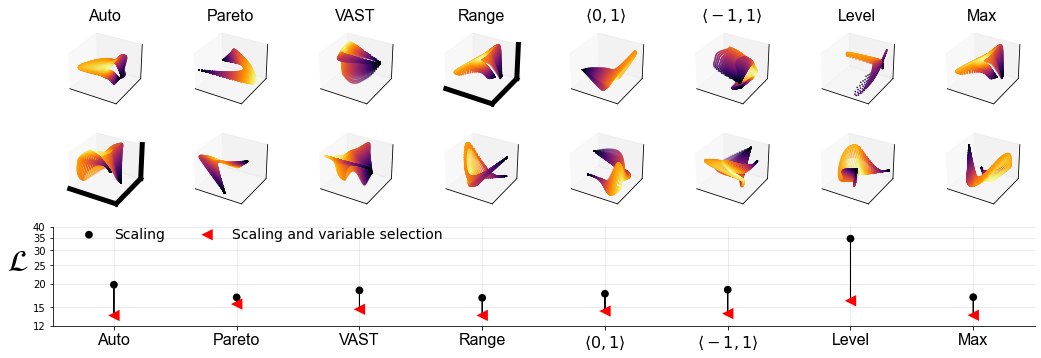

In [8]:
fig = plt.figure(figsize=(len(scalings_list)*2.2, 5.5))
fig.tight_layout(pad=-30)
spec = fig.add_gridspec(ncols=len(scalings_list), nrows=3, width_ratios=[1 for i in scalings_list], height_ratios=[1, 1, 1.2])

x_range = np.array([i for i in range(0,len(scalings_list))])

for i, scaling in enumerate(scalings_list):

    pca = reduction.PCA(state_space, scaling=scaling, n_components=3)
    PCs = pca.transform(state_space)
    PC_sources = pca.transform(state_space_sources, nocenter=True)

    ax = fig.add_subplot(spec[0,i:i+1], projection='3d')
    ax.scatter(PCs[:,0], PCs[:,1], PCs[:,2], c=state_space[:,0], s=0.5, cmap='inferno')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_title(tex_scalings_list[i], fontsize=16, **csfont)
    
    if i==best_scaling:
        for axis in [ax.w_xaxis, ax.w_yaxis, ax.w_zaxis]:
            axis.line.set_linewidth(5)

    subset_pca = reduction.PCA(state_space[:,selected_variables_backward[i]], scaling=scaling, n_components=3)
    subset_PCs = subset_pca.transform(state_space[:,selected_variables_backward[i]])
    subset_PC_sources = subset_pca.transform(state_space_sources[:,selected_variables_backward[i]], nocenter=True)

    ax = fig.add_subplot(spec[1,i:i+1], projection='3d')
    ax.scatter(subset_PCs[:,0], subset_PCs[:,1], subset_PCs[:,2], c=state_space[:,0], s=0.5, cmap='inferno')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    if i==best_subset_backward:
        for axis in [ax.w_xaxis, ax.w_yaxis, ax.w_zaxis]:
            axis.line.set_linewidth(5)

ax = fig.add_subplot(spec[2,0:len(scalings_list)])
plt.scatter(x_range, costs_pure_scaling, c='k', marker='o', s=60, edgecolor='none', alpha=1, zorder=3, label='Scaling')
plt.scatter(x_range, costs_subsetting_backward, c='r', marker='<', s=130, edgecolor='none', alpha=1, zorder=3, label='Scaling and variable selection')
plt.xticks(x_range, tex_scalings_list, fontsize=16, **csfont)
plt.grid(alpha=0.3, zorder=0)
plt.xlim([-0.5,len(x_range)-0.5])
plt.ylabel('$\mathcal{L}$', fontsize=30, rotation=0, horizontalalignment='right')
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
ax.set_yscale('log')
ax.set_yticks([12,15,20,25,30,35,40])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ylim([12,40])
lgnd = plt.legend(ncol=3, fontsize=14, markerscale=marker_scale_legend, loc="upper left", frameon=False, bbox_to_anchor=(0.01,1.12))

for i in range(0, len(scalings_list)):
    dy = np.min([costs_subsetting_backward[i], costs_subsetting_backward[i]]) - costs_pure_scaling[i]
    plt.arrow(x_range[i], costs_pure_scaling[i], 0, dy, color='k', ls='-', lw=1, zorder=2)

***